# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np

from empiricaldist import Cdf
import utils

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', context='talk')

## Load and inventory

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from 
https://gssdataexplorer.norc.org/projects/48515

In [2]:
!cp /home/downey/GssExtract/data/interim/gss_gun_control.hdf .

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_gun_control.hdf")

In [4]:
gss = pd.read_hdf("gss_gun_control.hdf", "gss")
print(gss.shape)
gss.head()

(68846, 16)


,age,cohort,educ,gun,gunlaw,hispanic,income,natcrime,owngun,polviews,race,realinc,sex,srcbelt,wtssall,year
0,23.0,1949.0,16.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,18951.0,2.0,3.0,0.4446,1972
1,70.0,1902.0,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,24366.0,1.0,3.0,0.8893,1972
2,48.0,1924.0,12.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,24366.0,2.0,3.0,0.8893,1972
3,27.0,1945.0,17.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,30458.0,2.0,3.0,0.8893,1972
4,61.0,1911.0,12.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,50763.0,2.0,3.0,0.8893,1972


In [5]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [6]:
replace_invalid(gss)
gss.shape

(68846, 16)

In [7]:
def numnull(series):
    return sum(series.isnull())

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [8]:
numnull(gss.gunlaw)

22841

In [9]:
utils.values(gss, 'gunlaw')

1.0    34724
2.0    11281
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [10]:
numnull(gss.owngun)

25764

In [11]:
utils.values(gss, 'owngun')

1.0    17042
2.0    26040
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [12]:
numnull(gss.gun)

49518

In [13]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [14]:
numnull(gss.natcrime)

31342

In [15]:
utils.values(gss, 'natcrime')

1.0    25220
2.0     9940
3.0     2344
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [16]:
varname = 'income'
numnull(gss[varname])

9217

In [17]:
utils.values(gss, varname)

1.0       878
2.0      1382
3.0      1294
4.0      1178
5.0      1302
6.0      1235
7.0      1300
8.0      2247
9.0      6663
10.0     5182
11.0     5334
12.0    31634
Name: income, dtype: int64

In [18]:
gss[varname].describe()

count    59629.000000
mean        10.117577
std          2.825647
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [19]:
varname = 'realinc'
numnull(gss[varname])

7044

In [20]:
gss[varname].describe()

count     61802.000000
mean      32214.421380
std       30289.927388
min         218.000000
25%       12197.000000
50%       24207.000000
75%       39919.000000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [21]:
varname = 'educ'
numnull(gss[varname])

243

In [22]:
utils.values(gss, varname)

0.0       174
1.0        48
2.0       154
3.0       260
4.0       320
5.0       404
6.0       843
7.0       884
8.0      2749
9.0      2115
10.0     2932
11.0     3826
12.0    20492
13.0     5637
14.0     7702
15.0     3118
16.0     9297
17.0     2225
18.0     2735
19.0     1033
20.0     1655
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [23]:
varname = 'polviews'
numnull(gss[varname])

9554

In [24]:
utils.values(gss, varname)

1.0     1889
2.0     7137
3.0     7500
4.0    22747
5.0     9166
6.0     8847
7.0     2006
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [25]:
numnull(gss.age)

561

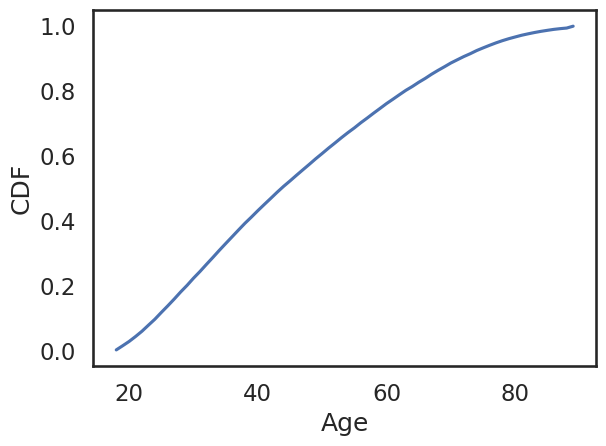

In [26]:
Cdf.from_seq(gss.age).plot()
utils.decorate(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [27]:
numnull(gss.cohort)

561

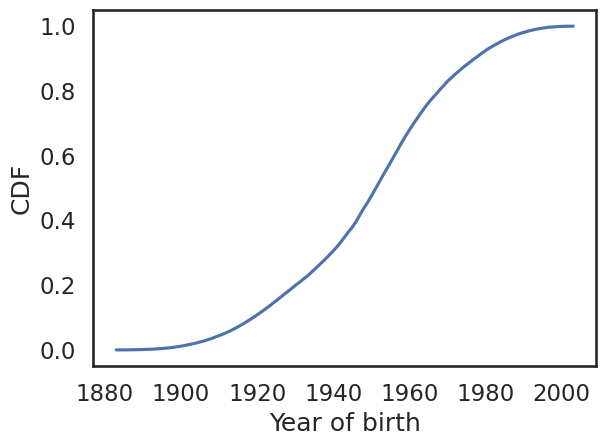

In [28]:
Cdf.from_seq(gss.cohort).plot()
utils.decorate(xlabel='Year of birth', ylabel='CDF')

In [29]:
utils.values(gss, 'cohort')

1883.0     2
1884.0     3
1885.0     7
1886.0     4
1887.0    13
          ..
1999.0    57
2000.0    46
2001.0    18
2002.0    14
2003.0     4
Name: cohort, Length: 121, dtype: int64

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [30]:
numnull(gss.sex)

92

In [31]:
utils.values(gss, 'sex')

1.0    30350
2.0    38404
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [32]:
numnull(gss.race)

54

In [33]:
utils.values(gss, 'race')

1.0    55143
2.0     9650
3.0     3999
Name: race, dtype: int64

### Hispanic 



In [34]:
numnull(gss.hispanic)

38198

In [35]:
utils.values(gss, 'hispanic')

1.0     27099
2.0      2130
3.0       435
4.0       151
5.0       107
6.0        68
7.0        19
8.0        21
9.0         8
10.0       32
11.0       44
15.0       90
16.0        1
20.0       31
21.0       46
22.0       51
23.0       19
24.0       13
25.0        5
30.0      182
31.0        2
35.0        8
40.0        5
41.0       27
42.0        1
45.0        3
46.0       14
47.0       23
50.0       13
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [36]:
numnull(gss.srcbelt)

4032

In [37]:
utils.values(gss, 'srcbelt')

1.0     5805
2.0     9015
3.0     7445
4.0     9786
5.0    24324
6.0     8439
Name: srcbelt, dtype: int64

## Remove rows missing key variables

In [38]:
gss.shape

(68846, 16)

In [39]:
gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
gss.shape

(45546, 16)

## Optionally, cut off recent data

In [40]:
cutoff = False

False

In [41]:
if cutoff:
    cutoff_year = 2016
    gss = gss[gss.year <= cutoff_year];

In [42]:
gss.shape

(45546, 16)

## Fill missing values

In [43]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    #print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [44]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    #print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [45]:
def fill_all_missing(df):
    varnames = ['owngun', 'gun', 'natcrime',
                'income', 'realinc', 'educ', 'polviews',
                'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
        
    # filling age is special because we have to fill cohort
    # to be consistent
    # but for generational analysis, we shouldn't fill age;
    # it just messes things up
    # fill_age(df)

In [46]:
fill_all_missing(gss)

### Make age and cohort groups

In [47]:
def RoundIntoBins(df, var, bin_width, high=None, low=0):
    """Rounds values down to the bin they belong in.

    df: DataFrame
    var: string variable name
    bin_width: number, width of the bins

    returns: array of bin values
    """
    if high is None:
        high = df[var].max()

    bins = np.arange(low, high+bin_width, bin_width)
    indices = np.digitize(df[var], bins)
    return bins[indices-1]

In [48]:
if cutoff:
    def make_groups(gss):
        gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5    
        gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
        gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5
        gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)
        gss['year8'] = utils.RoundIntoBins(gss, 'year', 8)
        gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
        gss['age10'] = utils.RoundIntoBins(gss, 'age', 10) + 5
        gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
        gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
else:
    def make_groups(gss):
        gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5    
        gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
        gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5
        gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)
        gss.loc[gss.cohort10==2000, 'cohort10'] = 1990
        gss['year8'] = utils.RoundIntoBins(gss, 'year', 8)
        gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1972) + 1
        gss['age10'] = utils.RoundIntoBins(gss, 'age', 10) + 5
        gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
        gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5

In [49]:
make_groups(gss)
gss.shape

(45546, 23)

Group people into 5- and 10-year bins by birth year.

In [50]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     156
1896.5     306
1901.5     566
1906.5     833
1911.5    1239
1916.5    1666
1921.5    2001
1926.5    2161
1931.5    2186
1936.5    2587
1941.5    3162
1946.5    4078
1951.5    4697
1956.5    4462
1961.5    3858
1966.5    3075
1971.5    2356
1976.5    1906
1981.5    1597
1986.5    1262
1991.5     848
1996.5     421
2001.5     123
Name: gunlaw, dtype: int64

In [51]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4230
1930.0    4882
1940.0    7530
1950.0    9139
1960.0    6628
1970.0    4111
1980.0    2718
1990.0    1166
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [52]:
utils.values(gss, 'year')

1972    1559
1973    1467
1974    1453
1975    1445
1976    1467
1977    1492
1980    1430
1982    1804
1984    1424
1985    1504
1987    1769
1988     944
1989    1012
1990     898
1991     975
1993    1051
1994    1953
1996    1878
1998    1835
2000    1807
2002     913
2004     889
2006    1958
2008    1329
2010    1269
2012    1278
2014    1686
2016    1850
2018    1539
2021    3668
Name: year, dtype: int64

Group into 4 year intervals.

In [53]:
utils.values(gss, 'year4')

1973    5924
1977    2959
1981    3234
1985    4697
1989    3829
1993    3004
1997    3713
2001    2720
2005    2847
2009    2598
2013    2964
2017    3389
2021    3668
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [54]:
utils.values(gss, 'age5')

17.5     752
22.5    3848
27.5    4754
32.5    4813
37.5    4608
42.5    4245
47.5    3828
52.5    3619
57.5    3425
62.5    3143
67.5    2875
72.5    2279
77.5    1678
82.5     970
87.5     709
Name: age5, dtype: int64

In [55]:
utils.values(gss, 'age3')

19.5    1394
22.5    2361
25.5    2690
28.5    2909
31.5    2889
34.5    2846
37.5    2824
40.5    2598
43.5    2509
46.5    2288
49.5    2269
52.5    2218
55.5    2049
58.5    2048
61.5    1954
64.5    1791
67.5    1723
70.5    1547
73.5    1282
76.5    1103
79.5     817
82.5     572
85.5     431
88.5     434
Name: age3, dtype: int64

### Make booleans

In [56]:
def copy_nan(df, varname, newvar):
    """Put a NaN into newvar in any place where varname is Nan.
    
    df: DataFrame
    varname: string old var name
    newvar: string new var name
    """
    df.loc[df[varname].isnull(), newvar] = np.nan

In [57]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [58]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    quantile25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= quantile25 
    copy_nan(df, 'realinc', 'lowrealinc')

    quantile75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= quantile75 
    copy_nan(df, 'realinc', 'highrealinc')

In [59]:
make_booleans(gss)

### Center cohort, age, and year.

In [60]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['y3'] = df.y**3
    df['ac'] = df.a * df.c

In [61]:
center_factors(gss)

In [62]:
for varname in ['c', 'a', 'y']:
    print(varname, gss[varname].mean())

c -17.099064681860096
a -0.5742545997453125
y 5.32668071839459


### Resample

Divide the sample up by year; resample within each year, using sampling weights; then concatenate the annual samples.

In [63]:
sample = utils.resample_by_year(gss).copy()
sample.shape

(45546, 59)

In [64]:
utils.values(sample, 'twenties')

False    41406
True      4140
Name: twenties, dtype: int64

In [65]:
utils.values(sample, 'thirties')

False    40585
True      4961
Name: thirties, dtype: int64

In [66]:
utils.values(sample, 'forties')

False    38325
True      7221
Name: forties, dtype: int64

In [67]:
utils.values(sample, 'fifties')

False    36448
True      9098
Name: fifties, dtype: int64

In [68]:
utils.values(sample, 'sixties')

False    38704
True      6842
Name: sixties, dtype: int64

In [69]:
utils.values(sample, 'seventies')

False    41183
True      4363
Name: seventies, dtype: int64

In [70]:
utils.values(sample, 'eighties')

False    42692
True      2854
Name: eighties, dtype: int64

In [71]:
utils.values(sample, 'nineties')

False    44084
True      1462
Name: nineties, dtype: int64

In [72]:
utils.values(sample, 'favor')

False    11345
True     34201
Name: favor, dtype: int64

In [73]:
utils.values(sample, 'gunhome')

False    26563
True     18983
Name: gunhome, dtype: int64

In [74]:
utils.values(sample, 'threatened')

False    36576
True      8970
Name: threatened, dtype: int64

In [75]:
utils.values(sample, 'spendcrime')

False    14686
True     30860
Name: spendcrime, dtype: int64

In [76]:
utils.values(sample, 'topincome')

False    20854
True     24692
Name: topincome, dtype: int64

In [77]:
utils.values(sample, 'lowincome')

False    37663
True      7883
Name: lowincome, dtype: int64

In [78]:
utils.values(sample, 'lowrealinc')

False    35539
True     10007
Name: lowrealinc, dtype: int64

In [79]:
utils.values(sample, 'highrealinc')

False    32550
True     12996
Name: highrealinc, dtype: int64

In [80]:
utils.values(sample, 'liberal')

False    32816
True     12730
Name: liberal, dtype: int64

In [81]:
utils.values(sample, 'moderate')

False    27977
True     17569
Name: moderate, dtype: int64

In [82]:
utils.values(sample, 'conservative')

False    37331
True      8215
Name: conservative, dtype: int64

In [83]:
utils.values(sample, 'female')

False    21114
True     24432
Name: female, dtype: int64

In [84]:
utils.values(sample, 'ishisp')

False    42113
True      3433
Name: ishisp, dtype: int64

In [85]:
utils.values(sample, 'black')

False    39237
True      6309
Name: black, dtype: int64

In [86]:
utils.values(sample, 'otherrace')

False    42757
True      2789
Name: otherrace, dtype: int64

In [87]:
utils.values(sample, 'urban')

False    18229
True     27317
Name: urban, dtype: int64

In [88]:
utils.values(sample, 'suburban')

False    33372
True     12174
Name: suburban, dtype: int64

In [89]:
utils.values(sample, 'rural')

False    39491
True      6055
Name: rural, dtype: int64

In [90]:
utils.values(sample, 'college')

False    24273
True     21273
Name: college, dtype: int64

## Create the resampled datasets

In [91]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [92]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby("year")
    samples = [resample_rows_weighted(group, column) for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [93]:
def run_resampling(iters=101):
    """Run the resampling process and save the results.
    
    iters: number of times to run
    """
    gss = pd.read_hdf("gss_gun_control.hdf", "gss")
    replace_invalid(gss)
    gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
    
    if cutoff:
        filename = 'iterations2016.hdf'
        gss = gss[gss.year <= 2016]
    else:
        filename = 'iterations2021.hdf'
    print(filename)
    print(gss.shape)
    
    for i in range(iters):
        sample = utils.resample_by_year(gss).copy()
        fill_all_missing(sample)
        make_groups(sample)
        make_booleans(sample)
        center_factors(sample)

        key = 'iter%d' % i
        #print('Writing', key)
        sample.to_hdf(filename, key)

In [94]:
%time run_resampling()

iterations2021.hdf
(45546, 16)


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',


CPU times: user 16.6 s, sys: 1.16 s, total: 17.7 s
Wall time: 17.7 s


/tmp/ipykernel_105455/2349016068.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block3_values] [items->Index(['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies',
       'eighties', 'nineties', 'favor', 'gunhome', 'threatened', 'spendcrime',
       'topincome', 'lowincome', 'liberal', 'moderate', 'conservative',
       'female', 'ishisp', 'black', 'otherrace', 'urban', 'suburban', 'rural',
       'college', 'lowrealinc', 'highrealinc'],
      dtype='object')]

  sample.to_hdf(filename, key)
